<a href="https://colab.research.google.com/github/tarun-09/Cricketer-s_Image_Classifier/blob/main/Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow

In [176]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, datasets, layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from keras.constraints import maxnorm
from sklearn.model_selection import train_test_split as tst

In [219]:
col_l = ['image', 'player']
df = pd.read_csv('/content/drive/MyDrive/dataset_/players.csv', usecols=col_l)
df.head()

images = []
players = []
frames = df.values.tolist()
for i in range(df.shape[0]):
    img = cv2.imread('/content/drive/MyDrive/dataset_/images/'+frames[i][1]+'/'+frames[i][0], 1)
    img = cv2.resize(img,(128,128))
    images.append(img)
    players.append(frames[i][1])


In [220]:
play = set(players)
play = sorted(play)
play = list(play)

for i in range(len(players)):
    players[i] = play.index(players[i])

x = np.array(images)
y = np.array(players)

play

['bhuvneshwar_kumar',
 'dinesh_karthik',
 'hardik_pandya',
 'jasprit_bumrah',
 'k._l._rahul',
 'kedar_jadhav',
 'kuldeep_yadav',
 'mohammed_shami',
 'ms_dhoni',
 'ravindra_jadeja',
 'rohit_sharma',
 'shikhar_dhawan',
 'vijay_shankar',
 'virat_kohli',
 'yuzvendra_chahal']

In [221]:
x_train, x_test, y_train, y_test = tst(x, y, test_size=0.15, random_state=10)

x_train=x_train.astype('float32')
x_test=x_test.astype('float32')

x_train = x_train/255.0
x_test = x_test/255.0

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

num_classes = y_test.shape[1]

In [222]:
datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [223]:
# earlystop= keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
epochs = 100
batch_size = 32

In [224]:
def define_model():
    cnn = models.Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_initializer='he_uniform',
                      activation='relu', input_shape= x_train[0].shape),
        layers.Dropout(0.2),
        layers.Conv2D(filters=32, kernel_size=(2, 2), kernel_constraint=maxnorm(3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=64, kernel_size=(2, 2), kernel_constraint=maxnorm(2), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        layers.Conv2D(filters=64, kernel_size=(2, 2),  kernel_constraint=maxnorm(2), padding='same', activation = 'relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),
        layers.Conv2D(filters=128, kernel_size=(2, 2),  kernel_constraint=maxnorm(2),  padding='same', activation = 'relu'),
        layers.MaxPooling2D((2,2)),
        # layers.Conv2D(filters=128, kernel_size=(2, 2),  kernel_constraint=maxnorm(2), padding='same', activation = 'relu'),
        # layers.MaxPooling2D((2,2)),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(1000, activation='relu', kernel_constraint=maxnorm(3), 
                     kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                     bias_regularizer=keras.regularizers.l2(1e-4),
                     activity_regularizer=keras.regularizers.l2(1e-5)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    sgd = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=(0.01 / 25), nesterov=False)
    cnn.compile(
        optimizer= 'adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return cnn


In [225]:
model = define_model()
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_111 (Conv2D)          (None, 128, 128, 32)      896       
_________________________________________________________________
dropout_103 (Dropout)        (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 128, 128, 32)      4128      
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 64, 64, 64)        8256      
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_104 (Dropout)        (None, 32, 32, 64)      

In [226]:
history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
                              # , callbacks=[earlystop])

Epoch 1/100
15/15 [==============================] - 3s 139ms/step - loss: 4.9916 - accuracy: 0.0786 - val_loss: 3.8145 - val_accuracy: 0.0345
Epoch 2/100
15/15 [==============================] - 2s 119ms/step - loss: 3.7944 - accuracy: 0.0803 - val_loss: 3.7461 - val_accuracy: 0.0460
Epoch 3/100
15/15 [==============================] - 2s 120ms/step - loss: 3.7136 - accuracy: 0.0828 - val_loss: 3.6813 - val_accuracy: 0.0920
Epoch 4/100
15/15 [==============================] - 2s 119ms/step - loss: 3.6398 - accuracy: 0.0788 - val_loss: 3.6196 - val_accuracy: 0.0575
Epoch 5/100
15/15 [==============================] - 2s 121ms/step - loss: 3.5922 - accuracy: 0.0752 - val_loss: 3.5662 - val_accuracy: 0.0460
Epoch 6/100
15/15 [==============================] - 2s 122ms/step - loss: 3.5158 - accuracy: 0.0931 - val_loss: 3.5124 - val_accuracy: 0.0805
Epoch 7/100
15/15 [==============================] - 2s 121ms/step - loss: 3.4482 - accuracy: 0.1028 - val_loss: 3.4750 - val_accuracy: 0.0460

In [227]:
_, acc = model.evaluate(x_test, y_test)
print('> %.3f' % (acc * 100.0))

3/3 [==============================] - 0s 11ms/step - loss: 3.1829 - accuracy: 0.4598
> 45.977


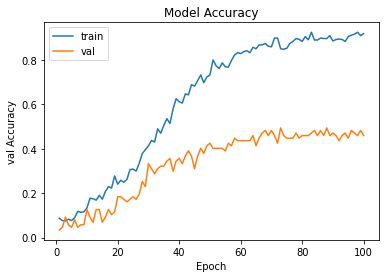

In [228]:
epoch_range=range(1, 101)
plt.plot(epoch_range, history.history['accuracy'])
plt.plot(epoch_range, history.history['val_accuracy'])
# plt.plot(epoch_range, history.history['loss'])
# plt.plot(epoch_range, history.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('val Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

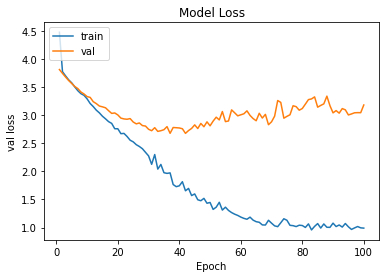

In [229]:
epoch_range=range(1, 101)
plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('val loss')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [230]:
y_preds=model.predict(x_test)
y_pred_labels = [np.argmax(i) for i in y_preds]
y_test_labels = [np.argmax(i) for i in y_test]


In [231]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
cm

array([[3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 2, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 7, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 3, 0, 1, 0, 0, 1, 1, 1, 0, 2, 0],
       [0, 0, 1, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
       [0, 0, 2, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 6, 1, 0, 2, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]])

Text(69.0, 0.5, 'Truth')

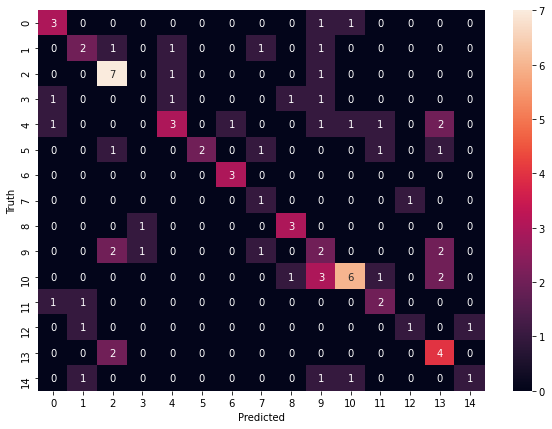

In [236]:
import seaborn as sn
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')


In [237]:
import imutils
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

In [238]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [241]:
image_file = take_photo()

<IPython.core.display.Javascript object>

[[223  34 197 197]
 [406 281  76  76]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
640 480


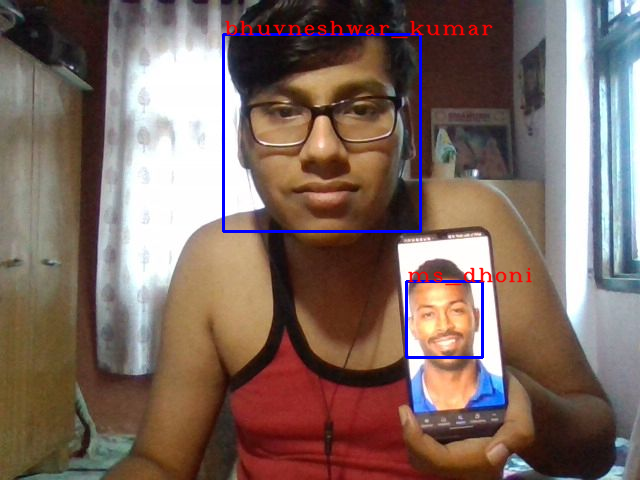

In [242]:
face_cascade = cv2.CascadeClassifier('/haarcascade_frontalface_default.xml')
image = cv2.imread(image_file, cv2.IMREAD_UNCHANGED)
image = cv2.imread(image_file)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.1, 5)
print(faces)

for (x, y, w, h) in faces:
            cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
            a = x
            b = y

            face = image[x : x+w, y : y+h]
            if(face.size != 0):
                face = cv2.resize(face,(128,128))
                ar = face.reshape(1,128,128,3)

                y_pred = model.predict(ar)
                print(y_pred)
                x = np.argmax(y_pred)
                txt = play[x]

                image = cv2.putText(image, txt , (a , b), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,0,255),1 , cv2.LINE_AA)

(h, w) = image.shape[:2]
print(w,h)
cv2_imshow(image)
